# Comparación: Muestreo Aleatorio Simple vs Muestreo Estratificado Óptimo (Neyman)
Este notebook compara cómo cambian las estimaciones de la media de horas de capacitación dependiendo del método de muestreo utilizado.En concreto muestra cómo las estimaciones de la media de horas de capacitación cambian dependiendo si usas muestreo aleatorio simple (MAS) o muestreo estratificado óptimo (Neyman)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(123)

df = pd.read_csv("poblacion_capacitacion.csv")
df.groupby("estrato")["horas"].describe()

,count,mean,std,min,25%,50%,75%,max
estrato,,,,,,,,
Administración,120.0,41.991811,20.428852,-15.762258,30.239805,43.096825,55.366446,91.197005
Producción,300.0,29.708141,10.282607,-2.310550,22.668493,29.817718,36.663193,59.586254
Ventas,180.0,34.025393,14.206146,-1.646137,24.997932,33.791876,45.102960,65.847010


##  Muestreo Aleatorio Simple (MAS)

In [2]:
mas_sample = df.sample(n=60, random_state=42)
mas_mean = mas_sample['horas'].mean()
mas_std = mas_sample['horas'].std(ddof=1)
mas_se = mas_std / np.sqrt(60)
mas_mean, mas_se

(np.float64(31.755883338469598), np.float64(2.0616571952758957))

## Muestreo Estratificado Óptimo (Neyman)

In [3]:
Nh = df['estrato'].value_counts().sort_index()
Sh = df.groupby('estrato')['horas'].std()
Nh_Sh = Nh * Sh
denominator = Nh_Sh.sum()
n = 60
nh_opt = np.round(n * Nh_Sh / denominator).astype(int)
nh_opt

,0
estrato,
Administración,18
Producción,23
Ventas,19


In [4]:
# Tomar muestras según Neyman
estratos = df['estrato'].unique()
muestras = []
for e in estratos:
    muestras.append(df[df['estrato'] == e].sample(n=nh_opt[e], random_state=42))
df_est = pd.concat(muestras)

# Estimación estratificada
Nh = Nh.sort_index()
Wh = Nh / Nh.sum()
yh = df_est.groupby('estrato')['horas'].mean()
mean_est = (Wh * yh).sum()

# Varianza estimada
Sh_est = df_est.groupby('estrato')['horas'].std()
var_est = ((Wh**2) * (Sh_est**2 / nh_opt)).sum()
se_est = np.sqrt(var_est)
mean_est, se_est

(np.float64(32.53206553814742), np.float64(1.5269905788826574))

## Comparación Visual

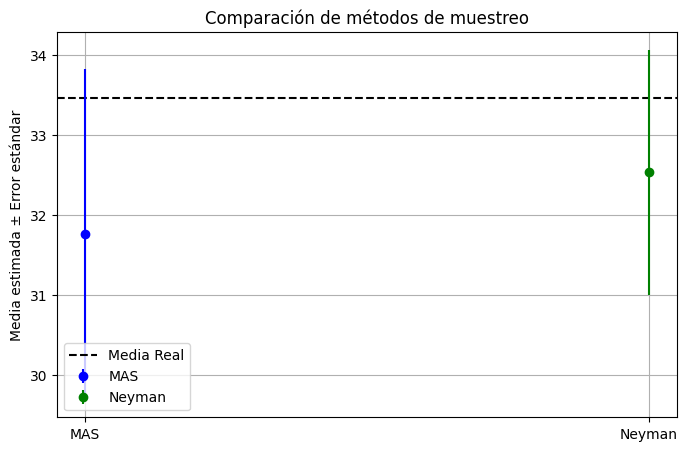

In [5]:
true_mean = df['horas'].mean()

plt.figure(figsize=(8,5))
plt.axhline(true_mean, color='black', linestyle='--', label='Media Real')
plt.errorbar(1, mas_mean, yerr=mas_se, fmt='o', label='MAS', color='blue')
plt.errorbar(2, mean_est, yerr=se_est, fmt='o', label='Neyman', color='green')
plt.xticks([1,2], ['MAS', 'Neyman'])
plt.ylabel('Media estimada ± Error estándar')
plt.title('Comparación de métodos de muestreo')
plt.grid(True)
plt.legend()
plt.show()